In [20]:
# %pip install python-dotenv
# %pip install seaborn
# %pip install tensorflow_data_validation

In [21]:
import os
import pandas as pd
import geopandas as gpd
import pygeos as pg
import numpy as np
import tensorflow as tf
import tensorflow_data_validation as tfdv
import sqlalchemy as sq
import sklearn as sk
import scipy as sp
import seaborn as sns
from dotenv import load_dotenv
from IPython.display import clear_output
from matplotlib import pyplot as plt
from DataService import DataService

In [22]:
# The following lines adjust the granularity of reporting.
#pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.chdir('/tf')
PGUSER = os.getenv('POSTGRES_USER')
PGPW = os.getenv('POSTGRES_PW')
PGDB = os.getenv('POSTGRES_DB')
NULLFLAG = -9999

In [23]:
# Connect to the database
pullService = DataService(PGDB, PGUSER, PGPW)
db_pull_con = pullService.connect()

pushService = DataService(PGDB, PGUSER, PGPW)
db_push_con = pushService.connect()

In [24]:
# Load the data
fireWeather = "FireWeather"
query = "SELECT * FROM public.\"{}\";".format(fireWeather)
dfEval = pd.read_sql(query, db_pull_con)

In [25]:
print(dfEval.count())
print(dfEval.describe())

EntryID                 428
FIRE_ID                 428
FIRENAME                428
YEAR                    428
MONTH                   428
DAY                     428
REP_DATE                428
SIZE_HA                 428
size_ha_bin             428
ClimateID               428
OneYear                 428
OneMonth                428
OneMeanTemp             428
OneMinTemp              428
OneMaxTemp              428
OneMeanDewPoint         428
OneMinDewPoint          428
OneMaxDewPoint          428
OneMeanHumidity         428
OneMinHumidity          428
OneMaxHumidity          428
OneMeanPressure         426
OneMinPressure          426
OneMaxPressure          426
OneMeanWindSpeed        426
OneMinWindSpeed         426
OneMaxWindSpeed         426
OneMeanWindChill        426
OneMinWindChill         426
OneMaxWindChill         426
OneTotalPrecip          428
OneMeanWindDirection    426
TwoYear                 428
TwoMonth                428
TwoMeanTemp             428
TwoMinTemp          

In [26]:
# Drop the columns that are not needed for the model
dfEval.drop(columns=['OneMonth', 'OneYear', 'TwoMonth', 'TwoYear'])
print(dfEval.count())
print(dfEval.head())

EntryID                 428
FIRE_ID                 428
FIRENAME                428
YEAR                    428
MONTH                   428
DAY                     428
REP_DATE                428
SIZE_HA                 428
size_ha_bin             428
ClimateID               428
OneYear                 428
OneMonth                428
OneMeanTemp             428
OneMinTemp              428
OneMaxTemp              428
OneMeanDewPoint         428
OneMinDewPoint          428
OneMaxDewPoint          428
OneMeanHumidity         428
OneMinHumidity          428
OneMaxHumidity          428
OneMeanPressure         426
OneMinPressure          426
OneMaxPressure          426
OneMeanWindSpeed        426
OneMinWindSpeed         426
OneMaxWindSpeed         426
OneMeanWindChill        426
OneMinWindChill         426
OneMaxWindChill         426
OneTotalPrecip          428
OneMeanWindDirection    426
TwoYear                 428
TwoMonth                428
TwoMeanTemp             428
TwoMinTemp          

In [27]:
# split data into train validate test 6 2 2
# dfTrain = dfEval.sample(frac=0.6, random_state=0)
# dfTest = dfEval.drop(dfTrain.index)
# dfTest = dfTest.sample(frac=0.5, random_state=0)
# dfValidate = dfEval.drop(dfTrain.index)
# dfValidate = dfValidate.drop(dfTest.index)

In [28]:
# randomly select 6 years from 2010-2019 for training
dfTrain = dfEval[dfEval['YEAR'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016])]
dfValidate = dfEval[dfEval['YEAR'].isin([2017, 2018])]
dfTest = dfEval[dfEval['YEAR'].isin([2019, 2020])]

In [29]:
# Store our random selection, run once
# randomTrain = "RandomTrain"
# dfTrain.to_sql(randomTrain, db_push_con, if_exists='replace', index=False)

# randomTest = "RandomTest"
# dfTest.to_sql(randomTest, db_push_con, if_exists='replace', index=False)

# randomValidate = "RandomValidate"
# dfValidate.to_sql(randomValidate, db_push_con, if_exists='replace', index=False)

In [30]:
trainStats = tfdv.generate_statistics_from_dataframe(dfTrain)

In [31]:
tfdv.visualize_statistics(trainStats)


In [32]:
schema = tfdv.infer_schema(statistics=trainStats)
tfdv.display_schema(schema=schema)


,Type,Presence,Valency,Domain
Feature name,,,,
'EntryID',INT,required,,-
'FIRE_ID',BYTES,required,,-
'FIRENAME',BYTES,required,,-
'YEAR',INT,required,,-
'MONTH',INT,required,,-
'DAY',INT,required,,-
'REP_DATE',BYTES,required,,-
'SIZE_HA',FLOAT,required,,-
'size_ha_bin',INT,required,,-


,Values
Domain,
'ClimateID',"'2202200', '2202202', '3062696', '3062697', '3072655', '4060983', '4061620', '4061629', '4063605', '4064155', '4067655', '406QLD0', '5061649'"


In [33]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay


In [34]:
Y_train = dfTrain['SIZE_HA'].copy(deep=True)
Y_train.fillna(Y_train.mean(), inplace=True)

Y_train_discrete = dfTrain['size_ha_bin'].copy(deep=True)
Y_train_discrete.fillna(Y_train_discrete.min(), inplace=True)

X_train = dfTrain.drop(columns=['MONTH', 'SIZE_HA', 'OneMonth', 'OneYear', 'TwoMonth', 'TwoYear', 'EntryID', 'size_ha_bin', 'YEAR', 'DAY', 'FIRE_ID', 'FIRENAME', 'ClimateID', 'REP_DATE'])
X_train.fillna(X_train.mean(), inplace=True)
X_train_one = X_train.drop(columns=['TwoMeanTemp', 'TwoMinTemp', 'TwoMaxTemp', 'TwoMeanDewPoint', 'TwoMinDewPoint', 'TwoMaxDewPoint',
                                     'TwoMeanHumidity', 'TwoMinHumidity', 'TwoMaxHumidity', 'TwoMeanPressure', 'TwoMinPressure',
                                     'TwoMaxPressure', 'TwoMeanWindSpeed', 'TwoMinWindSpeed', 'TwoMaxWindSpeed', 'TwoMeanWindChill',
                                     'TwoMinWindChill', 'TwoMaxWindChill', 'TwoTotalPrecip', 'TwoMeanWindDirection'])
X_train_two = X_train.drop(columns=['OneMeanTemp', 'OneMinTemp', 'OneMaxTemp', 'OneMeanDewPoint', 'OneMinDewPoint', 'OneMaxDewPoint',
                                     'OneMeanHumidity', 'OneMinHumidity', 'OneMaxHumidity', 'OneMeanPressure', 'OneMinPressure',
                                     'OneMaxPressure', 'OneMeanWindSpeed', 'OneMinWindSpeed', 'OneMaxWindSpeed', 'OneMeanWindChill',
                                      'OneMinWindChill', 'OneMaxWindChill', 'OneTotalPrecip', 'OneMeanWindDirection'])

X_train_means_one = X_train_one.drop(columns=['OneMinTemp', 'OneMaxTemp', 'OneMinDewPoint', 'OneMaxDewPoint', 'OneMinHumidity', 'OneMaxHumidity',
                                              'OneMinPressure', 'OneMaxPressure', 'OneMinWindSpeed', 'OneMaxWindSpeed', 'OneMinWindChill',
                                              'OneMaxWindChill'])

X_train_means_two = X_train_two.drop(columns=['TwoMinTemp', 'TwoMaxTemp', 'TwoMinDewPoint', 'TwoMaxDewPoint', 'TwoMinHumidity', 'TwoMaxHumidity',
                                                'TwoMinPressure', 'TwoMaxPressure', 'TwoMinWindSpeed', 'TwoMaxWindSpeed', 'TwoMinWindChill',
                                                'TwoMaxWindChill'])

dfTrainScaled = dfTrain.copy(deep=True)
dfTrainScaled.fillna(dfTrainScaled.mean(), inplace=True)
dfTrainScaled = dfTrainScaled.drop(columns=['MONTH', 'OneMonth', 'OneYear', 'TwoMonth', 'TwoYear', 'EntryID', 'size_ha_bin', 'YEAR', 'DAY', 'FIRE_ID', 'FIRENAME', 'ClimateID', 'REP_DATE'])

/tmp/ipykernel_30791/365260978.py:27: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfTrainScaled.fillna(dfTrainScaled.mean(), inplace=True)


In [35]:
# regularize y values using z score
dfTrainScaled = (dfTrainScaled - dfTrainScaled.mean()) / dfTrainScaled.std()
# set max value to 3 zscore
dfTrainScaled[dfTrainScaled > 3] = 3
# set min value to -3 zscore
dfTrainScaled[dfTrainScaled < -3] = -3

# shift the wole train set to be positive
dfTrainScaled = dfTrainScaled + 3

In [36]:
# regularize y using log scale
Y_train = np.log(Y_train)
# regularize y values using z score
Y_train = (Y_train - Y_train.mean()) / Y_train.std()
# set max value to 3 zscore
Y_train[Y_train > 3] = 3

In [37]:
X_train.count()

OneMeanTemp             336
OneMinTemp              336
OneMaxTemp              336
OneMeanDewPoint         336
OneMinDewPoint          336
OneMaxDewPoint          336
OneMeanHumidity         336
OneMinHumidity          336
OneMaxHumidity          336
OneMeanPressure         336
OneMinPressure          336
OneMaxPressure          336
OneMeanWindSpeed        336
OneMinWindSpeed         336
OneMaxWindSpeed         336
OneMeanWindChill        336
OneMinWindChill         336
OneMaxWindChill         336
OneTotalPrecip          336
OneMeanWindDirection    336
TwoMeanTemp             336
TwoMinTemp              336
TwoMaxTemp              336
TwoMeanDewPoint         336
TwoMinDewPoint          336
TwoMaxDewPoint          336
TwoMeanHumidity         336
TwoMinHumidity          336
TwoMaxHumidity          336
TwoMeanPressure         336
TwoMinPressure          336
TwoMaxPressure          336
TwoMeanWindSpeed        336
TwoMinWindSpeed         336
TwoMaxWindSpeed         336
TwoMeanWindChill    

train_dataset = X_train_means_one.copy(deep=True)
train_dataset['SIZE_HA'] = Y_train
pairplotOne = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

train_dataset = X_train_means_two.copy(deep=True)
train_dataset['SIZE_HA'] = Y_train
pairplotTwo = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

In [38]:
dfall = X_train_means_one.copy(deep=True)
dfall['SIZE_HA'] = Y_train

In [39]:
print(Y_train.describe())
print(Y_train.isnull().sum().sum())
print(X_train_means_one.count())
print(X_train_means_one.isna().sum().sum())
print(X_train_means_one.dtypes)

count   336.0
mean     -0.0
std       1.0
min      -1.6
25%      -0.8
50%      -0.1
75%       0.6
max       3.0
Name: SIZE_HA, dtype: float64
0
OneMeanTemp             336
OneMeanDewPoint         336
OneMeanHumidity         336
OneMeanPressure         336
OneMeanWindSpeed        336
OneMeanWindChill        336
OneTotalPrecip          336
OneMeanWindDirection    336
dtype: int64
0
OneMeanTemp             float64
OneMeanDewPoint         float64
OneMeanHumidity         float64
OneMeanPressure         float64
OneMeanWindSpeed        float64
OneMeanWindChill        float64
OneTotalPrecip          float64
OneMeanWindDirection    float64
dtype: object


## Define functions that build and train a model

The following code defines two functions:

  * `build_model(my_learning_rate)`, which builds a randomly-initialized model.
  * `train_model(model, feature, label, epochs)`, which trains the model from the examples (feature and label) you pass. 

Since you don't need to understand model building code right now, we've hidden this code cell.  You may optionally double-click the following headline to see the code that builds and trains a model.

In [40]:
#@title Define the functions that build and train a model
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(1,)))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model        


def train_model(model, df, feature, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs. 
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs)

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # To track the progression of training, we're going to take a snapshot
  # of the model's root mean squared error at each epoch. 
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

print("Defined the build_model and train_model functions.")

Defined the build_model and train_model functions.


## Define plotting functions

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) functions create the following plots:

*  a scatter plot of the feature vs. the label, and a line showing the output of the trained model
*  a loss curve

You may optionally double-click the headline to see the matplotlib code, but note that writing matplotlib code is not an important part of learning ML programming.

In [41]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against 200 random training examples."""

  # Label the axes.
  plt.xlabel(feature)
  plt.ylabel(label)

  # Create a scatter plot from 200 random points of the dataset.
  random_examples = dfTrainScaled.sample(n=200)
  plt.scatter(random_examples[feature], random_examples[label])

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = 6
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()  

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


## Call the model functions

An important part of machine learning is determining which [features](https://developers.google.com/machine-learning/glossary/#feature) correlate with the [label](https://developers.google.com/machine-learning/glossary/#label). For example, real-life home-value prediction models typically rely on hundreds of features and synthetic features. However, this model relies on only one feature. For now, you'll arbitrarily use `total_rooms` as that feature. 


2022-11-29 03:54:48.006256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


Epoch 1/30


2022-11-29 03:54:48.022742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-29 03:54:48.022988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-29 03:54:48.023880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 03:54:48.024408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built witho

68/68 [==============================] - 1s 6ms/step - loss: 1.1554 - root_mean_squared_error: 1.0749
Epoch 2/30
68/68 [==============================] - 0s 6ms/step - loss: 0.9532 - root_mean_squared_error: 0.9763
Epoch 3/30
68/68 [==============================] - 0s 6ms/step - loss: 0.8235 - root_mean_squared_error: 0.9075
Epoch 4/30
68/68 [==============================] - 0s 6ms/step - loss: 0.7187 - root_mean_squared_error: 0.8478
Epoch 5/30
68/68 [==============================] - 0s 6ms/step - loss: 0.6267 - root_mean_squared_error: 0.7916
Epoch 6/30
68/68 [==============================] - 0s 6ms/step - loss: 0.5326 - root_mean_squared_error: 0.7298
Epoch 7/30
68/68 [==============================] - 0s 6ms/step - loss: 0.4630 - root_mean_squared_error: 0.6804
Epoch 8/30
68/68 [==============================] - 0s 6ms/step - loss: 0.4064 - root_mean_squared_error: 0.6375
Epoch 9/30
68/68 [==============================] - 0s 6ms/step - loss: 0.3627 - root_mean_squared_error: 0

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


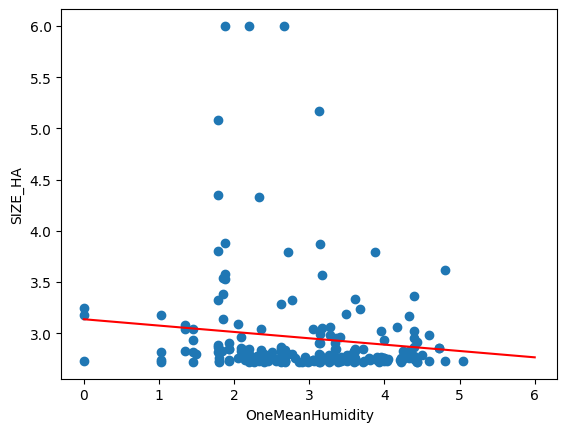

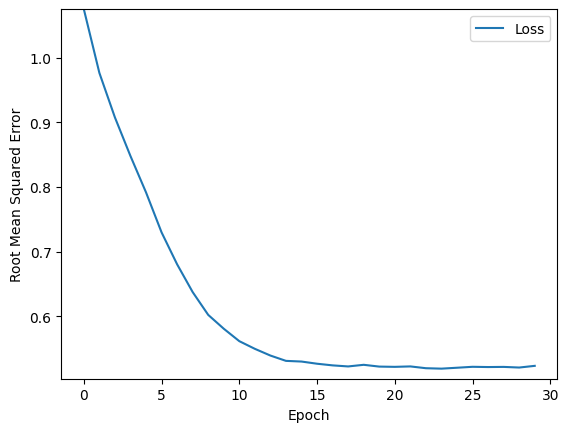

In [42]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 30
batch_size = 5

# Specify the feature and the label.
my_feature = "OneMeanHumidity"  # the total number of rooms on a specific city block.
my_label="SIZE_HA" # the median value of a house on a specific city block.
#my_label="size_ha_bin"
# That is, you're going to create a model that predicts house value based 
# solely on total_rooms.  

# Discard any pre-existing version of the model.
my_model = None

# Invoke the functions.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, dfTrainScaled, 
                                         my_feature, my_label,
                                         epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

## Use the model to make predictions

You can use the trained model to make predictions. In practice, [you should make predictions on examples that are not used in training](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data). However, for this exercise, you'll just work with a subset of the same training dataset. A later Colab exercise will explore ways to make predictions on examples not used in training.

First, run the following code to define the house prediction function:

In [43]:
def predict_house_values(n, feature, label):
  """Predict house values based on a feature."""

  batch = dfTrainScaled[feature][200:200 + n]
  predicted_values = my_model.predict_on_batch(x=batch)

  print("feature   label          predicted")
  print("  value   value          value")
  print("          in thousand$   in thousand$")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f %15.0f" % (dfTrain[feature][400+i], dfTrain[label][400+i], predicted_values[i][0] ))

In [44]:
predict_house_values(10, my_feature, my_label)

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
   51   3829               3
   51   1012               3
   60   1210               3
   60    231               3
   60   1877               3
   60   2895               3
   60    585               3
   48  27136               3
   38    464               3
   38  15061               3


/tmp/ipykernel_30791/3036197316.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  batch = dfTrainScaled[feature][200:200 + n]
